In this notebook we look at the test FID scores of the models as well as how well we can use them to interpolate in the latent space.

### 0.) MNIST

In [37]:
import torch
import pandas as pd
from fid_score import FID2
from training_tools import load_data, imshow
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = load_data("mnist",test=True)
latent_dim = 50

In [3]:
generator = torch.load("mnist_generator.pt").cpu().eval()
decoderNP = torch.load("mnist_NP_decoder.pt").cpu().eval()
decoderNFP = torch.load("mnist_NFP_decoder.pt").cpu().eval()

### Random Samples

In [8]:
plt.rcParams["figure.figsize"] = (5,5)

In [11]:
X = torch.randn(64, latent_dim)

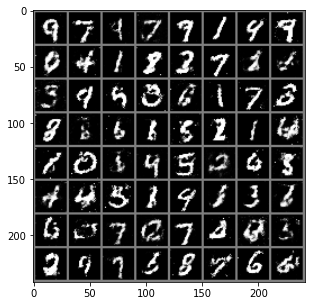

In [14]:
# gan
X_ = generator(X).reshape(64,1,28,28).detach()
imshow(X_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


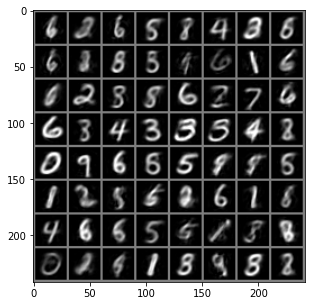

In [15]:
# vae np
X_ = decoderNP(X)[0].reshape(64,1,28,28).detach()
imshow(X_)

C:\Users\leo\anaconda3\envs\asr_project\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


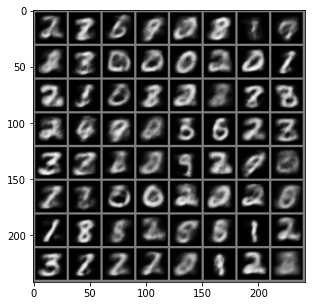

In [16]:
# vae nfp
X_ = decoderNFP(X)[0].reshape(64,1,28,28).detach()
imshow(X_)

Visually, the VAE with normal prior seems to produce the best looking images.

## FID on the test set

In order to test the generative models, we draw batches of size 100 from both the test set and the latent distribution to calculate the pairwise FID score. A size of 100 is computationally feasable, such that we can obtain the distribution of scores over the whole test set. Of course, Using a single batch of 10k images would be even better given that the FID score incorporates basic batch statistics that would be more meaningful for larger batches.

In [33]:
%%time
res = []
N = len(data)
for i in range(0, N, 100):
    X = torch.randn(100, latent_dim)
    real = data[i:i+100]
    gan = generator(X).reshape(100,1,28,28).detach()
    dec_NP = decoderNP(X)[0].reshape(100,1,28,28).detach()
    dec_NFP = decoderNFP(X)[0].reshape(100,1,28,28).detach()
    res.append(dict(gan = FID2(real, gan, False),
                     NP  = FID2(real, dec_NP, False),
                     NFP = FID2(real, dec_NFP, False)
                        ))

Wall time: 6min 21s


<AxesSubplot:>

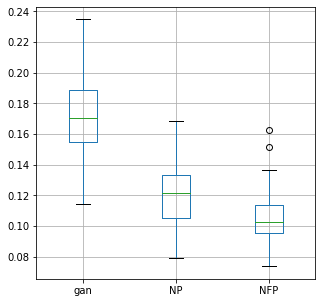

In [34]:
pd.DataFrame(res).boxplot()

Although the visual inspection clearly favors the VAE with NP, the VAE with NFP has the lowest FID score on avergae.

### Latent Space interpolation

In [65]:
plt.rcParams["figure.figsize"] = (7,7)

In [135]:
X1 = torch.randn(1, latent_dim)
X2 = torch.randn(1, latent_dim)

interpolation_gan = torch.cat([generator(torch.lerp(X1, X2, _)).reshape(1,1,28,28).detach() for _ in np.linspace(0,1, 32)])
interpolation_np = torch.cat([decoderNP(torch.lerp(X1, X2, _))[0].reshape(1,1,28,28).detach() for _ in np.linspace(0,1, 32)])
interpolation_nfp = torch.cat([decoderNFP(torch.lerp(X1, X2, _))[0].reshape(1,1,28,28).detach() for _ in np.linspace(0,1, 32)])

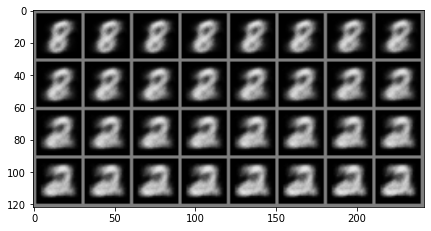

In [136]:
imshow(interpolation_nfp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


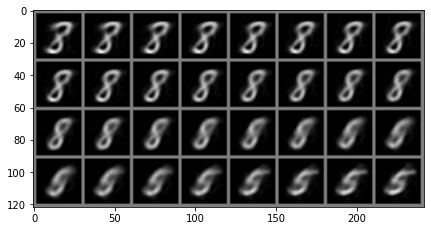

In [137]:
imshow(interpolation_np)

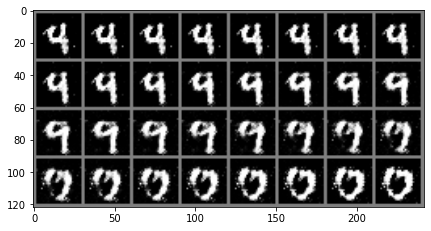

In [178]:
imshow(interpolation_gan)

Overall (not only based on these 3 samples) the VAEs tend to have a more smooth latent space, which is indicates by the smooth transition over multiple latent points. The GAN is less smooth in this regard. Interesting in the example above is the fact that we interpolate through 3 digit representations (GAN)!

### 1.) SVHN

In [17]:
import torch
from fid_score import FID, FID2
import numpy as np
from training_tools import load_data, imshow
import matplotlib.pyplot as plt

In [2]:
data = load_data("svhn", test=True)
latent_dim = 50

Using downloaded and verified file: ./SVHN/dataset\test_32x32.mat


In [3]:
generator = torch.load("svhn_generator.pt").cpu().eval()
decoderNP = torch.load("svhn_NP_decoder.pt").cpu().eval()
decoderNFP = torch.load("svhn_NFP_decoder.pt").cpu().eval()

In [9]:
X = torch.randn(64, latent_dim)

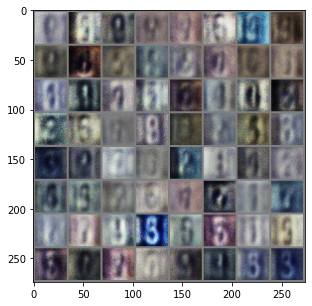

In [10]:
# gan
X_ = generator(X).reshape(64,3,32,32).detach()
imshow(X_)

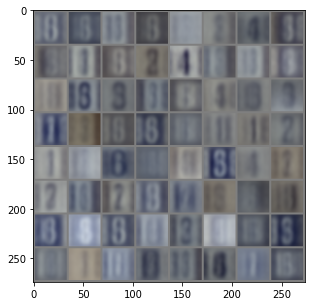

In [11]:
# vae np
X_ = decoderNP(X)[0].reshape(64,3,32,32).detach()
imshow(X_)

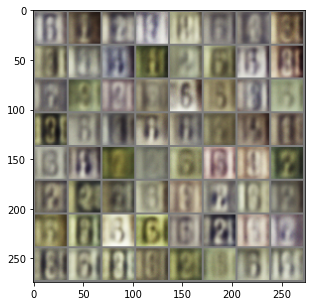

In [12]:
# vae nfp
X_ = decoderNFP(X)[0].reshape(64,3,32,32).detach()
imshow(X_)

The GAN generates more colorful images, but its hard to tell which model is producing the best since the actual training data is also quite noisy and rather low quality.

## FID on the test set

In order to test the generative models, we draw batches of size 100 from both the test set and the latent distribution to calculate the pairwise FID score. A size of 100 is computationally feasable, such that we can obtain the distribution of scores over the whole test set. Of course, Using a single batch of 10k images would be even better given that the FID score incorporates basic batch statistics that would be more meaningful for larger batches.

In [ ]:
%%time
res = []
N = 10_000 # like mnist
for i in range(0, N, 100):
    X = torch.randn(100, latent_dim)
    real = data[i:i+100]
    gan = generator(X).reshape(100,3,32,32).detach()
    dec_NP = decoderNP(X)[0].reshape(100,3,32,32).detach()
    dec_NFP = decoderNFP(X)[0].reshape(100,3,32,32).detach()
    res.append(dict(gan = FID2(real, gan, False),
                     NP  = FID2(real, dec_NP, False),
                     NFP = FID2(real, dec_NFP, False)
                        ))

<AxesSubplot:>

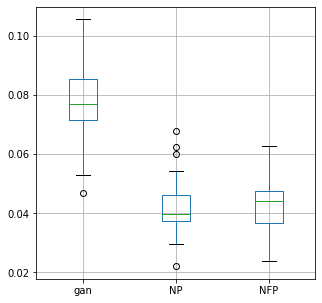

In [21]:
pd.DataFrame(res).boxplot()

According to the test set, the VAE-NP has the lowest avergae score, but the VAE NFP is very close.

### Latent Space interpolation

In [51]:
plt.rcParams["figure.figsize"] = (11,11)

In [60]:
X1 = torch.randn(1, latent_dim)
X2 = torch.randn(1, latent_dim)

interpolation_gan = torch.cat([generator(torch.lerp(X1, X2, _)).reshape(1,3,32,32).detach() for _ in np.linspace(0,1, 8)])
interpolation_np = torch.cat([decoderNP(torch.lerp(X1, X2, _))[0].reshape(1,3,32,32).detach() for _ in np.linspace(0,1, 8)])
interpolation_nfp = torch.cat([decoderNFP(torch.lerp(X1, X2, _))[0].reshape(1,3,32,32).detach() for _ in np.linspace(0,1, 8)])



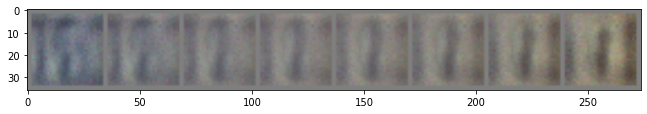

In [61]:
imshow(interpolation_gan)

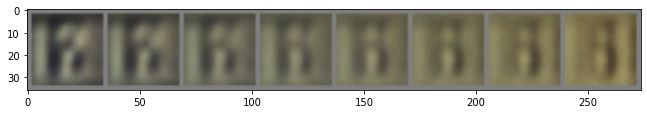

In [62]:
imshow(interpolation_nfp)

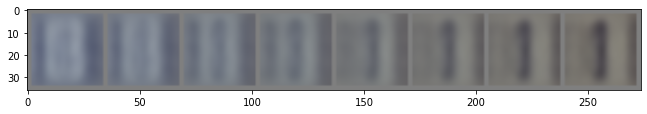

In [63]:
imshow(interpolation_np)